In [30]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from utils import *
import os
from scipy.io.matlab.mio import loadmat, savemat
import numpy as np
from PIL import Image
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch import nn, optim
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

C:\Users\Nassim\AppData\Local\Temp\ipykernel_24904\2369603914.py:9: DeprecationWarning: Please use `loadmat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat
C:\Users\Nassim\AppData\Local\Temp\ipykernel_24904\2369603914.py:9: DeprecationWarning: Please use `savemat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat


In [2]:
path_imgs = './data/portraits/'
path_imgs_edited = './data/Player_output/Photoshop/'

list_imgs = os.listdir(path_imgs)
list_imgs_edited = os.listdir(path_imgs_edited)

d_imgs = dict() 
d_edited_names = dict()

for img_name in list_imgs : 
    d_imgs[img_name] = np.array(Image.open(path_imgs + img_name))
    
    list_imgs_name_edited = [x for x in list_imgs_edited if x.startswith(img_name[:-4] + "_")]
    d_edited_names[img_name] = list_imgs_name_edited

    for img_name_edited in list_imgs_name_edited : 
        d_imgs[img_name_edited] = np.array(Image.open(path_imgs_edited + img_name_edited))
    



In [3]:
from PIL import Image 
import PIL

save_pair_folder = "./data/pair_tmp/"

dataset = []
for img in d_edited_names : 
    for edited_img in d_edited_names[img] : 
        d = np.hstack((d_imgs[img], d_imgs[edited_img]))
        dataset.append(d)
        i = Image.fromarray(d)
        i.save(save_pair_folder + edited_img[:-4] + "_pair.jpg")
        

In [32]:
path_pair_img = 'data/photoshoptest'

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=path_pair_img, transform=image_transform)

batch_size = 5
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


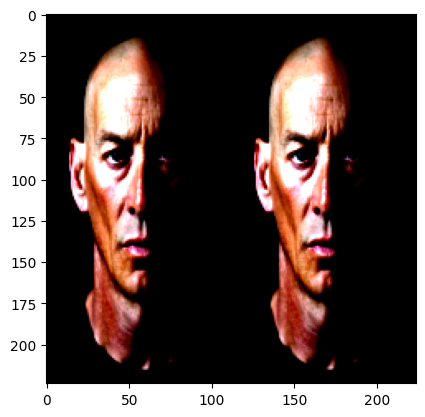

In [33]:
image = dataset[0][0]
image = image.permute(1, 2, 0)
plt.imshow(image.numpy())

In [34]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(46656, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 8)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [42]:
model = LeNet().to(device)
print(model)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=8, bias=True)
)


In [43]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [44]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [49]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    #Used to calculate the confusion matrix
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X, y in dataloader:
            y_true.extend(y.data.cpu().numpy())

            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            
            y_pred.extend(pred.argmax(1).data.cpu().numpy())

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    # labels = np.ndarray(["Diffuse", "Edges", "Guassian", "pinch", "Sharpen", "Surface", "Twirl", "Wave"])

    conf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot()
    plt.show()
    

CrossValidation : 0
-------------------------------

Epoch 1
-------------------------------
loss: 2.073130  [  100/ 5260]
Test Error: 
 Accuracy: 35.3%, Avg loss: 1.486445 



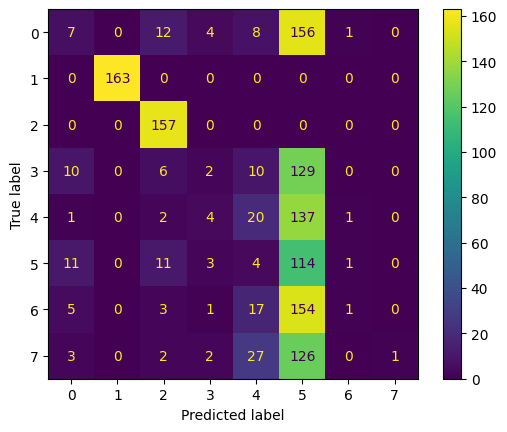

Epoch 2
-------------------------------
loss: 1.490230  [  100/ 5260]
Test Error: 
 Accuracy: 46.7%, Avg loss: 1.186442 



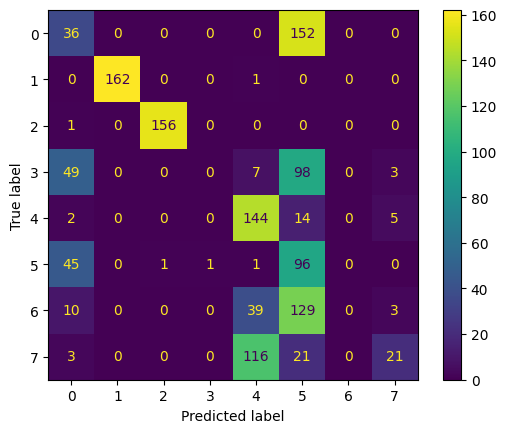

Epoch 3
-------------------------------
loss: 1.225805  [  100/ 5260]
Test Error: 
 Accuracy: 51.2%, Avg loss: 1.015759 



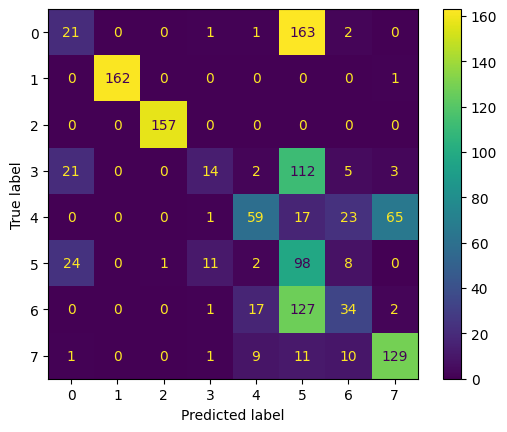

Epoch 4
-------------------------------
loss: 0.975811  [  100/ 5260]
Test Error: 
 Accuracy: 56.8%, Avg loss: 0.956821 



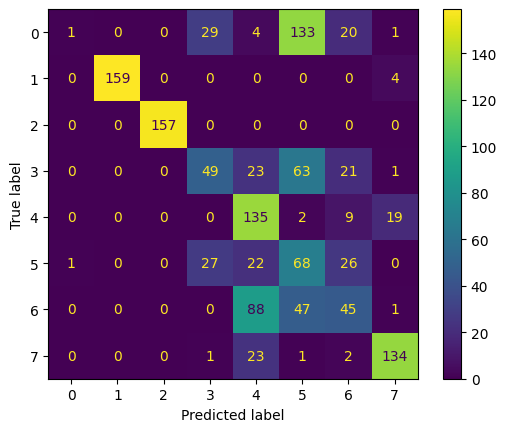

Epoch 5
-------------------------------
loss: 0.746982  [  100/ 5260]
Test Error: 
 Accuracy: 65.3%, Avg loss: 0.857961 



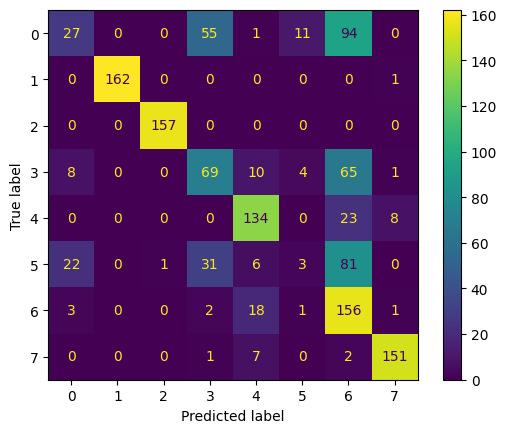

Epoch 6
-------------------------------
loss: 0.759526  [  100/ 5260]
Test Error: 
 Accuracy: 64.7%, Avg loss: 0.820990 



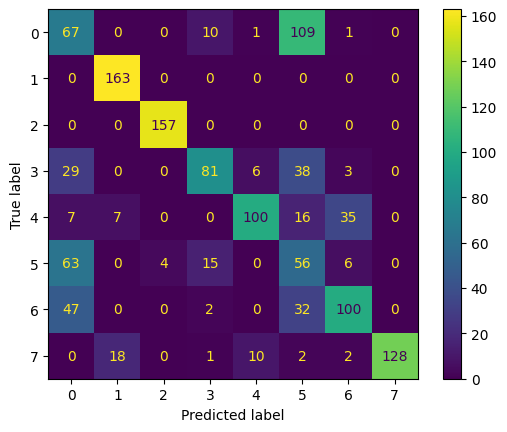

Epoch 7
-------------------------------
loss: 0.506915  [  100/ 5260]
Test Error: 
 Accuracy: 71.2%, Avg loss: 0.680763 



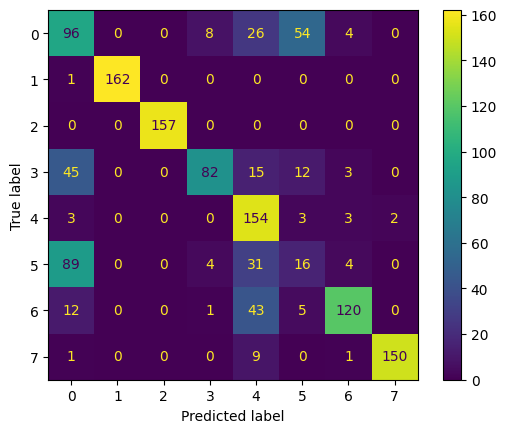

Epoch 8
-------------------------------
loss: 0.391338  [  100/ 5260]
Test Error: 
 Accuracy: 64.7%, Avg loss: 0.940292 



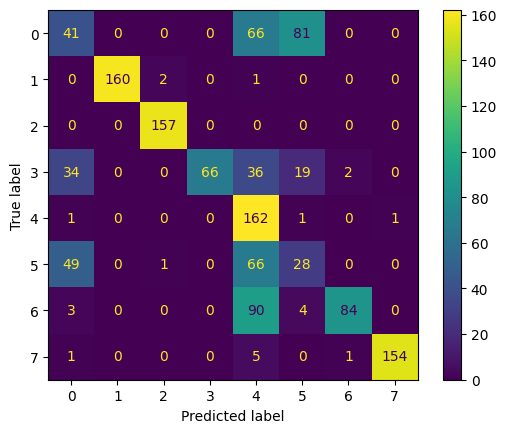

Epoch 9
-------------------------------
loss: 0.404908  [  100/ 5260]
Test Error: 
 Accuracy: 76.0%, Avg loss: 0.489852 



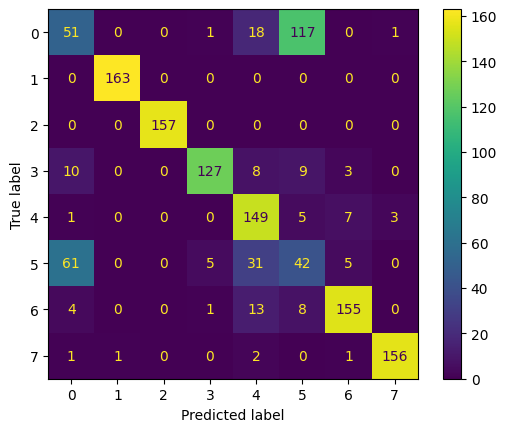

Epoch 10
-------------------------------
loss: 0.227138  [  100/ 5260]
Test Error: 
 Accuracy: 72.4%, Avg loss: 0.568304 



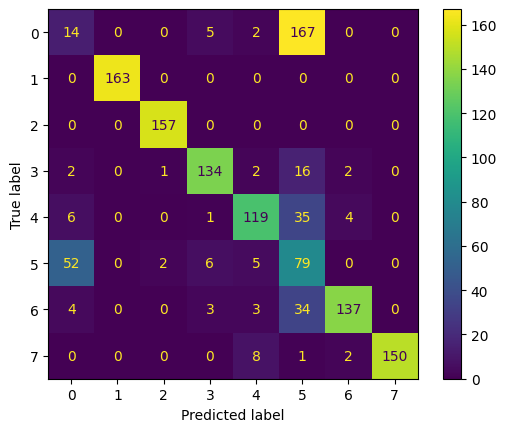

Epoch 11
-------------------------------
loss: 0.283734  [  100/ 5260]
Test Error: 
 Accuracy: 78.3%, Avg loss: 0.637179 



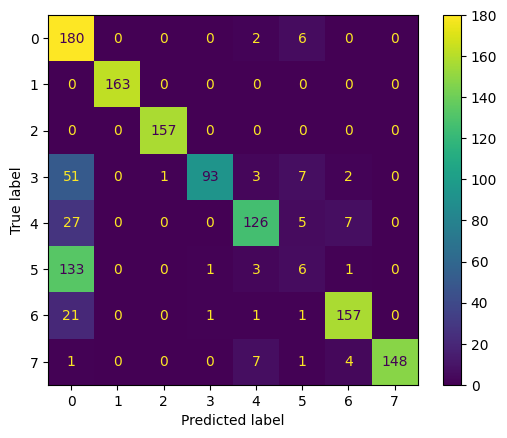

Epoch 12
-------------------------------
loss: 0.325057  [  100/ 5260]
Test Error: 
 Accuracy: 78.6%, Avg loss: 0.455185 



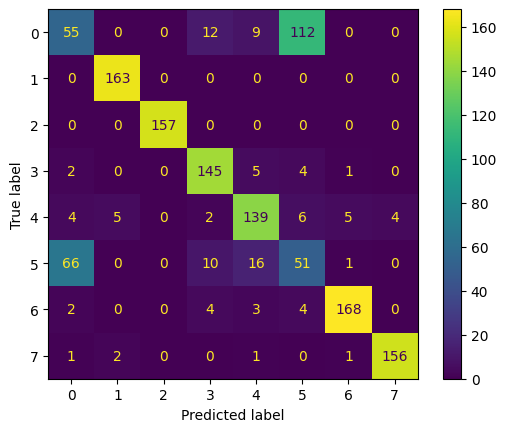

Epoch 13
-------------------------------
loss: 0.268221  [  100/ 5260]
Test Error: 
 Accuracy: 76.9%, Avg loss: 0.516464 



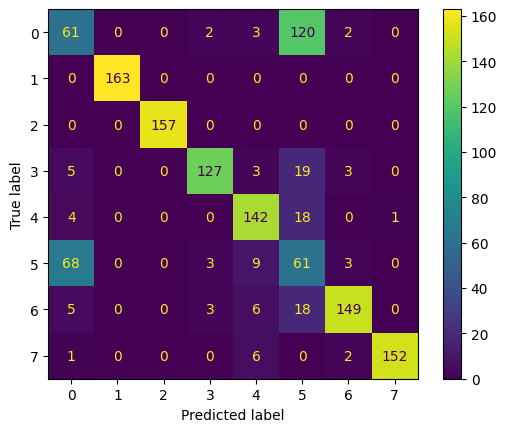

Epoch 14
-------------------------------
loss: 0.179319  [  100/ 5260]
Test Error: 
 Accuracy: 79.4%, Avg loss: 0.538713 



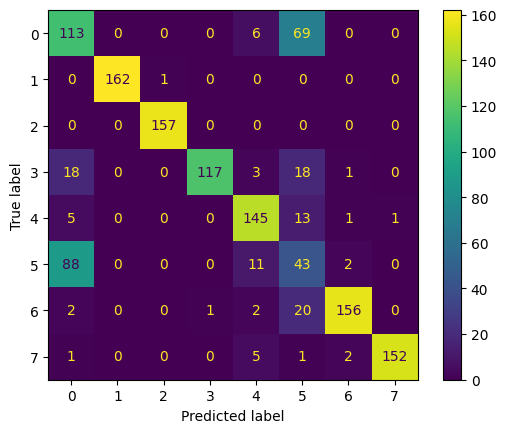

Epoch 15
-------------------------------
loss: 0.123473  [  100/ 5260]
Test Error: 
 Accuracy: 76.9%, Avg loss: 0.511466 



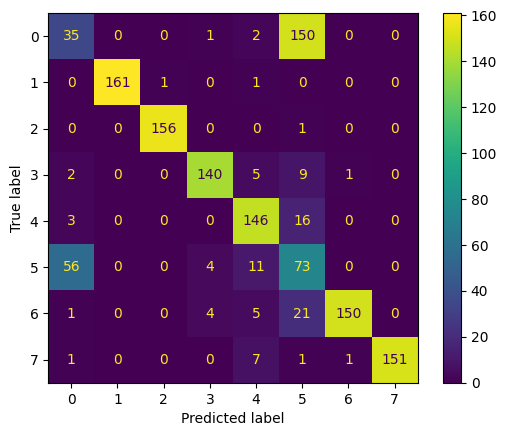

Epoch 16
-------------------------------
loss: 0.204956  [  100/ 5260]
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.458882 



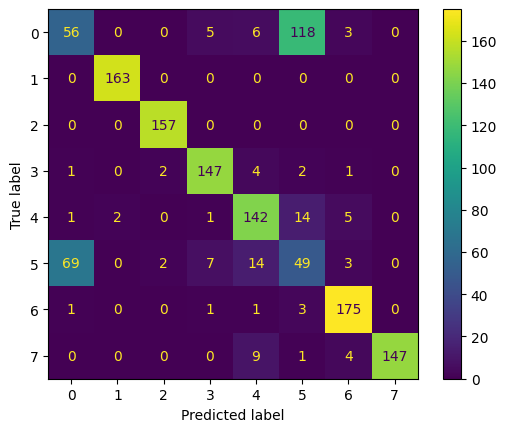

Epoch 17
-------------------------------
loss: 0.109242  [  100/ 5260]
Test Error: 
 Accuracy: 78.4%, Avg loss: 0.489277 



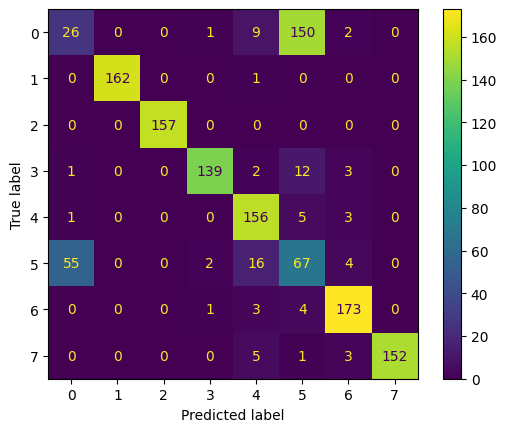

Epoch 18
-------------------------------
loss: 0.166641  [  100/ 5260]
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.571711 



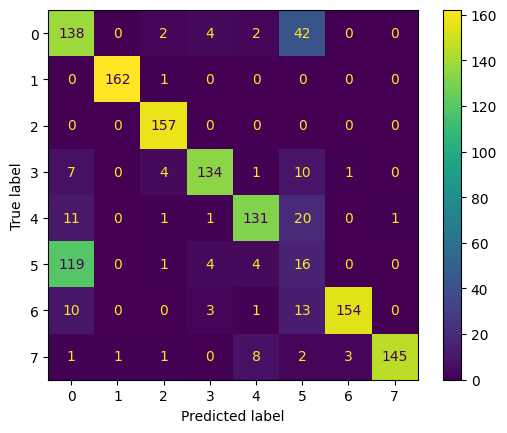

Epoch 19
-------------------------------
loss: 0.143738  [  100/ 5260]


KeyboardInterrupt: 

In [50]:
epochs = 20

for i in range(5):
    model = LeNet().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    print("CrossValidation : "+str(i)+"\n-------------------------------\n")
    train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)


    # Create the data loaders for training and validation
    train_dataloader = torch.utils.data.DataLoader(
        train_data,
        batch_size=100,
        shuffle=True
    )

    test_dataloader = torch.utils.data.DataLoader(
        test_data,
        batch_size=100,
        shuffle=False
    )
    
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        #test(test_dataloader, model, loss_fn)
        test(test_dataloader, model, loss_fn)
    print("Done!")